# KoGPT 모델 LoRA로 학습하기

- 학습 내용
  - [KoGPT](https://github.com/kakaobrain/kogpt) 파라미터를 직접 Fine-Tuning하는 대신 Low Rank 어댑터만 학습하는 LoRA 기법을 사용합니다.
  - HuggingFace에서 제공하는 [PEFT: Parameter-Efficient Fine-Tuning](https://github.com/huggingface/peft) 라이브러리를 활용합니다.
  - 학습 결과는 15MB 정도 크기의 어댑터 파라미터만 저장해도 재사용 할 수 있습니다.  

  
- 환경 필요사항
  - 학습에는 GPU 메모리가 많이 필요하므로 colab 사용 시 유료 요금제 사용을 권장합니다.
  - 구글 드라이브에 `/GPT_Competition/train.csv`, `/GPT_Competition/test.csv`가 업로드 되어있어야 합니다.
  - 학습 결과를 구글드라이브에 저장하므로 약간의 여유공간이 필요합니다.

In [ ]:
!nvidia-smi

Wed Mar 29 00:58:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 구글 드라이브와 연동합니다. 권한 허용이 필요합니다.
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# 라이브러리를 설치합니다.
%pip install -q transformers datasets accelerate
%pip install -q peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import os, gc
from tqdm.auto import tqdm
from datetime import datetime, timezone, timedelta

import torch
from torch.utils.data import DataLoader,Dataset

import datasets
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.optimization import get_cosine_schedule_with_warmup

# HuggingFace peft 라이브러리
from peft import get_peft_model, PeftModel, TaskType, LoraConfig

## 데이터 셋 정의하기
- HuggingFace의 Dataset 클래스를 활용합니다. batch 단위로 전처리하기 편리합니다.
- tokenizer 클래스는 batch 단위로 처리하면 속도가 빠릅니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',
)

In [ ]:
# 테스트 데이터를 HuggingFace Dataset으로 불러옵니다.
data_path = '/content/drive/MyDrive/my_data/220320_kogpt/train_short.csv'
train_s_df = pd.read_csv(data_path)
train_s_set = datasets.Dataset.from_pandas(train_s_df)
del train_s_df

In [ ]:
data_path = '/content/drive/MyDrive/my_data/220320_kogpt/train_long.csv'
train_l_df = pd.read_csv(data_path)
train_l_set = datasets.Dataset.from_pandas(train_l_df)
del train_l_df

In [ ]:
data_path = '/content/drive/MyDrive/my_data/220320_kogpt/test.csv'
test_df = pd.read_csv(data_path)
test_set = datasets.Dataset.from_pandas(test_df)
del test_df

- [Batch mapping](https://huggingface.co/docs/datasets/about_map_batch) 기능을 활용하여 데이터 셋 전체를 미리 토큰화합니다.
- `{text} 한줄 요약: {summary} [EOS]` 형태로 input을 만듭니다. 문장 끝 토큰 `[EOS]`를 직접 추가합니다.
- input에서 생성하려는 `{summary} [EOS]` 부분만 정답 label로 남기고 나머지는 ignore_index인 -100으로 가립니다.
- [GPTJForCausalLM](https://huggingface.co/docs/transformers/model_doc/gptj#transformers.GPTJForCausalLM) 모델에 input_ids와 labels를 넘겨주면 logits과 loss를 계산해줍니다.
- loss 는 모델이 예측한 logits과 정답 label의 [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)로 계산하며 -100인 부분은 계산에서 제외됩니다.

In [ ]:
def train_batch_preprocess(batch):
    prompt = "{text} 한줄 요약:"
    query_text = [prompt.format(text=text) for text in batch['text']]
    target_text = batch['summary']
    query = tokenizer(query_text)
    target = tokenizer(target_text)

    input_ids = [q + t + [tokenizer.eos_token_id] for q, t in zip(query['input_ids'], target['input_ids'])]
    attention_mask = [q + t + [1] for q, t in zip(query['attention_mask'], target['attention_mask'])]
    labels = [[-100] * len(q) + t + [tokenizer.eos_token_id] for q, t in zip(query['input_ids'], target['input_ids'])]

    # 결과로 돌려주는 값들이 추가됩니다.
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [ ]:
# batch단위로 전처리를 실행합니다.
# 토큰화 이후에 id, text, summary는 필요없으므로 버립니다.
train_s_set = train_s_set.map(
    train_batch_preprocess,
    remove_columns = ['id', 'text', 'summary'],
    batched = True,
    batch_size = 1000,
)

Map:   0%|          | 0/28816 [00:00<?, ? examples/s]

In [ ]:
# 데이터프레임화 합니다.
train_s_df = pd.DataFrame(train_s_set)
train_s_df.head(2)

,Unnamed: 0,length,input_ids,attention_mask,labels
0,10800,1040,"[2850, 10286, 527, 167, 893, 23149, 387, 17516...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, -100, -100, -100, -100, -100, -100, -10..."
1,10801,740,"[2850, 10286, 527, 167, 893, 4144, 409, 8555, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, -100, -100, -100, -100, -100, -100, -10..."


In [ ]:
# 토큰 개수를 바탕으로 길이를 확인합니다.
train_s_df['length'] = train_s_df['input_ids'].apply(len)

# 데이터 프레임을 저장합니다.
train_s_df.to_csv('/content/train_s_token.csv', encoding='utf-8')

In [ ]:
# batch단위로 전처리를 실행합니다.
# 토큰화 이후에 id, text, summary는 필요없으므로 버립니다.
train_l_set = train_l_set.map(
    train_batch_preprocess,
    remove_columns = ['id', 'text', 'summary'],
    batched = True,
    batch_size = 1000,
)

Map:   0%|          | 0/11584 [00:00<?, ? examples/s]

In [ ]:
train_l_df = pd.DataFrame(train_l_set)
train_l_df.head(2)

,Unnamed: 0,length,input_ids,attention_mask,labels
0,0,1204,"[10181, 13817, 465, 657, 746, 1421, 1141, 779,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, -100, -100, -100, -100, -100, -100, -10..."
1,1,1240,"[38916, 1141, 463, 3877, 1805, 447, 3460, 4843...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, -100, -100, -100, -100, -100, -100, -10..."


In [ ]:
# 토큰 개수를 바탕으로 길이를 확인합니다.
train_l_df['length'] = train_l_df['input_ids'].apply(len)

# 데이터 프레임을 저장합니다.
train_l_df.to_csv('/content/train_l_token.csv', encoding='utf-8')

# 여기서 부터 파일 있으면 진행

In [ ]:
import ast

def converter(x):
    # 문자열을 받아 리스트로 변환
    return ast.literal_eval(x)

converters={'input_ids': converter,
            'attention_mask' : converter,
            'labels' : converter}

# 토큰 csv 파일을 불러옵니다.
train_df = pd.read_csv(f'{ROOT}/train_token_cut.csv', converters=converters)
# train_l_df = pd.read_csv('/content/drive/MyDrive/my_data/220320_kogpt/train_l_cut50.csv', converters=converters)

In [ ]:
train_s_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27814 entries, 0 to 27813
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   length          27814 non-null  int64 
 1   input_ids       27814 non-null  object
 2   attention_mask  27814 non-null  object
 3   labels          27814 non-null  object
dtypes: int64(1), object(3)
memory usage: 869.3+ KB


In [ ]:
# csv 파일을 기존 dict로 변환합니다.
train_s_set = datasets.Dataset.from_pandas(train_s_df)
train_l_set = datasets.Dataset.from_pandas(train_l_df)

In [ ]:
# 결과를 확인합니다.
# (eos_token_id = 1, ignore_index = -100)
print(train_s_set)
print(len(train_s_set[0]['input_ids']))
print(train_s_set[0]['input_ids'])
print(train_s_set[0]['attention_mask'])
print(train_s_set[0]['labels'])

Dataset({
    features: ['length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 13012
})
393
[982, 32634, 1598, 167, 893, 9678, 502, 463, 860, 3542, 523, 487, 496, 3281, 120, 1484, 9309, 1172, 470, 3523, 22314, 458, 1334, 813, 4283, 409, 499, 771, 743, 120, 10086, 1210, 21493, 4587, 3658, 2742, 963, 3984, 1172, 1060, 660, 62607, 986, 743, 120, 10086, 6375, 1740, 6930, 803, 2927, 4020, 2209, 1569, 812, 409, 1069, 413, 11815, 395, 6335, 4385, 463, 19414, 402, 812, 9226, 499, 447, 821, 395, 426, 743, 120, 10086, 1210, 21493, 4587, 3658, 4340, 3343, 387, 532, 496, 1732, 8197, 1064, 13487, 657, 10219, 4219, 376, 3361, 1105, 743, 120, 3531, 474, 447, 4219, 1519, 376, 1380, 14294, 1105, 387, 467, 2675, 640, 803, 15188, 10244, 470, 3523, 9140, 413, 487, 395, 544, 496, 461, 4144, 7506, 10244, 470, 1064, 1411, 2528, 463, 4385, 379, 732, 971, 409, 10790, 387, 4018, 584, 467, 426, 1455, 1440, 376, 1729, 2958, 137, 108, 63997, 2460, 21493, 4587, 6396, 2742, 963, 167, 893, 6626, 379, 2168

In [ ]:
print(type(train_s_set[0]['input_ids']))

<class 'list'>


- train_set은 각 샘플마다 길이가 다릅니다.
- 길이가 서로 다른 샘플을 하나의 배치로 만들기 위해 collate_fn 함수를 작성합니다.
- GPTJ는 문장의 오른쪽 끝부터 생성하는 autoregressive 모델이므로 오른쪽 끝이 같아야합니다. left padding을 사용합니다.
- attention_mask는 0, labels는 -100으로 padding합니다.

In [ ]:
def left_pad(sequence, value, max_len):
    return [value] * (max_len - len(sequence)) + sequence

def collate_fn(batch, device='cuda'):
    length = max(len(row['input_ids']) for row in batch)
    
    input_ids = [
        left_pad(row['input_ids'], tokenizer.pad_token_id, length)
        for row in batch
    ]
    attention_mask = [
        left_pad(row['attention_mask'], 0, length)
        for row in batch
    ]
    labels = [
        left_pad(row['input_ids'], -100, length)
        for row in batch
    ]
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long , device=device),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long , device=device),
        'labels': torch.tensor(labels, dtype=torch.long , device=device),
    }

In [ ]:
train_s_loader = DataLoader(
    train_s_set, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn,
)

In [ ]:
train_l_loader = DataLoader(
    train_l_set, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn,
)

## 모델 불러오기
- base model을 불러온뒤 peft model로 감싸줍니다.

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    'kakaobrain/kogpt', revision = 'KoGPT6B-ryan1.5b-float16',
    torch_dtype = torch.float16,
    device_map = 'auto',
)

config
- TaskType: 앞문장에서 뒷문장을 생성하는 CAUSAL_LM입니다.
- r: LoRA에 사용할 rank입니다.
- lora_alpha: LoRA α 계수입니다. (B @ A * α/r) 형태로 들어가는 scale 계수입니다.
- lora_dropout: A, B 보다 앞에 추가할 Dropout 레이어의 drop 비율입니다.
- target_modules: LoRA를 적용할 모듈입니다. `List[str]` 형태이면 해당 키워드로 끝나는 모듈에, `str` 형태이면 정규식에 해당하는 모듈에 적용됩니다.

In [ ]:
peft_config = LoraConfig(
    task_type = TaskType.CAUSAL_LM,
    r=8, lora_alpha=32, lora_dropout=0.1,
    target_modules = ['q_proj', 'v_proj'],
    # target_modules = r".*(q_proj|v_proj)",
)

In [ ]:
print(peft_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, base_model_name_or_path=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, r=8, target_modules=['q_proj', 'v_proj'], lora_alpha=32, lora_dropout=0.1, merge_weights=False, fan_in_fan_out=False, enable_lora=None, bias='none', modules_to_save=None)


In [ ]:
peft_model_s = get_peft_model(base_model, peft_config)
peft_model_s.to('cuda')
peft_model_s.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTJForCausalLM(
      (transformer): GPTJModel(
        (wte): Embedding(64512, 4096)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0): GPTJBlock(
            (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (attn): GPTJAttention(
              (attn_dropout): Dropout(p=0.1, inplace=False)
              (resid_dropout): Dropout(p=0.0, inplace=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): Dropout(p=0.1, inplace=False)
                (lora_A): Linear(in_features=4096, out_features=8, bias=False)
                (lora_B): Linear(in_features=8, out_features=4096, bias=False)
              )
              (q_proj): Linear(
                in_features=4096, out_features=4096, bias=False
               

In [ ]:
peft_model_l = get_peft_model(base_model, peft_config)
peft_model_l.to('cuda')
peft_model_l.train()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/peft/mapping.py:145 in get_peft_model                     │
│                                                                                                  │
│   142 │   │   peft_config = _prepare_lora_config(peft_config, model_config)                      │
│   143 │   else:                                                                                  │
│   144 │   │   peft_config = _prepare_prompt_learning_config(peft_config, model_config)           │
│ ❱ 145 │   return MODEL_TYPE_TO_PEFT_MODEL_MAPPING[peft_config.task_type](model, peft_config)     │
│   146                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/peft/peft_model.py:514 in __init__                        │
│                                                                                                  │
│   511 │   """                                                                                    │
│   512 │                                                                                          │
│   513 │   def __init__(self, model, peft_config: PeftConfig):                                    │
│ ❱ 514 │   │   super().__init__(model, peft_config)                                               │
│   515 │   │   self.base_model_prepare_inputs_for_generation = self.base_model.prepare_inputs_f   │
│   516 │   │   self.base_model.prepare_inputs_for_generation = self.prepare_inputs_for_generati   │
│   517                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/peft/peft_model.py:79 in __init__                         │
│                                                                                                  │
│    76 │   │   if isinstance(self.peft_config, PromptLearningConfig):                             │
│    77 │   │   │   self._setup_prompt_encoder()                                                   │
│    78 │   │   else:                                                                              │
│ ❱  79 │   │   │   self.base_model = LoraModel(peft_config, model)                                │
│    80 │   │   if getattr(self.peft_config, "modules_to_save", None) is not None:                 │
│    81 │   │   │   self.modules_to_save = self.peft_config.modules_to_save                        │
│    82 │   │   │   _set_trainable(self)                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/peft/tuners/lora.py:118 in __init__                       │
│                                                                                                  │
│   115 │   │   super().__init__()                                                                 │
│   116 │   │   self.peft_config = config                                                          │
│   117 │   │   self.model = model                                                                 │
│ ❱ 118 │   │   self._find_and_replace()                                                           │
│   119 │   │   mark_only_lora_as_trainable(self.model, self.peft_config.bias)                     │
│   120 │   │   self.forward = self.model.forward                                                  │
│   121                                                      

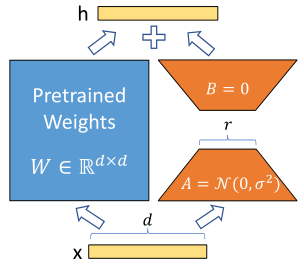

- LoRA peft 모델이 어떤 파라미터를 가지는지 확인해 봅시다.
- lora_A, lora_B 이외에는 freeze인 것이 확인 됩니다.

In [ ]:
pd.DataFrame([
    (param.dtype, param.shape, param.device, param.requires_grad, name)
    for name, param in peft_model_s.named_parameters()
], columns=['dtype', 'shape', 'device', 'requires_grad', 'name'])

,dtype,shape,device,requires_grad,name
0,torch.float16,"(64512, 4096)",cuda:0,False,base_model.model.transformer.wte.weight
1,torch.float16,"(4096,)",cuda:0,False,base_model.model.transformer.h.0.ln_1.weight
2,torch.float16,"(4096,)",cuda:0,False,base_model.model.transformer.h.0.ln_1.bias
3,torch.float16,"(4096, 4096)",cuda:0,False,base_model.model.transformer.h.0.attn.k_proj.w...
4,torch.float16,"(4096, 4096)",cuda:0,False,base_model.model.transformer.h.0.attn.v_proj.w...
...,...,...,...,...,...
392,torch.float16,"(4096,)",cuda:0,False,base_model.model.transformer.h.27.mlp.fc_out.bias
393,torch.float16,"(4096,)",cuda:0,False,base_model.model.transformer.ln_f.weight
394,torch.float16,"(4096,)",cuda:0,False,base_model.model.transformer.ln_f.bias
395,torch.float16,"(64512, 4096)",cuda:0,False,base_model.model.lm_head.weight


## 학습

- float32, float16이 섞여있으므로 amp autocast를 활용합니다.

#### Callbacks

- Warmup Scheduler와 ReduceLRonpleatu 사용

In [ ]:
# Warmup Scheduler
class WarmupLR(torch.optim.lr_scheduler.LambdaLR):

    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        warmup_end_steps: int,
        last_epoch: int = -1,
    ):
        
        def wramup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        
        super().__init__(optimizer, wramup_fn, last_epoch)


In [ ]:
warmup_ratio = 0.2
NUM_EPOCHS = 15

total_steps = len(train_s_loader) * NUM_EPOCHS
warmup_step = int(total_steps * warmup_ratio)

print(f"전체 학습 스텝은 다음과 같습니다: {total_steps}")
print(f"전체 학습 스텝 중 warmup 스텝은 다음과 같습니다: {warmup_step}")

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=total_steps)

전체 학습 스텝은 다음과 같습니다: 97590
전체 학습 스텝 중 warmup 스텝은 다음과 같습니다: 19518


In [ ]:
learning_rate = 1e-4

optimizer = torch.optim.AdamW(peft_model_s.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=0.0001, threshold_mode='rel', cooldown=total_steps//NUM_EPOCHS, min_lr=1e-6, verbose=True)


In [ ]:
def training_step(model, batch, optimizer, scaler):
    global count
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        outputs = model(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_mask'],
            labels = batch['labels'],
        )
        step_loss = outputs[0]
    scaler.scale(step_loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # Warmup
    scheduler1.step()
    if count > warmup_step:
        # ReduceLR
        scheduler2.step(step_loss)
    count += 1
    return step_loss.detach()

In [ ]:
import torch 
import gc

torch.cuda.empty_cache() 
gc.collect()

185

In [ ]:
# short - 기존 Train 저점 205
NUM_EPOCHS = 15
count = 0

peft_model_s.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    tr_loss = torch.tensor(0.0).to('cuda')
    for batch_idx, batch in enumerate(tqdm(train_s_loader), start=1):
        step_loss = training_step(peft_model_s, batch, optimizer, scaler)
        tr_loss += step_loss
        if batch_idx % 100 == 0:
            print("{}. tr_loss: {}".format(batch_idx, tr_loss.item()))
            tr_loss = torch.tensor(0.0).to('cuda')

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 238.0094451904297
200. tr_loss: 225.57733154296875
300. tr_loss: 224.61671447753906
400. tr_loss: 216.5074005126953
500. tr_loss: 219.62139892578125
600. tr_loss: 218.24615478515625
700. tr_loss: 219.50906372070312
800. tr_loss: 218.00746154785156
900. tr_loss: 219.2874755859375
1000. tr_loss: 219.4072723388672
1100. tr_loss: 215.79806518554688
1200. tr_loss: 212.89149475097656
1300. tr_loss: 214.53077697753906
1400. tr_loss: 215.25033569335938
1500. tr_loss: 215.756103515625
1600. tr_loss: 211.7695770263672
1700. tr_loss: 213.73155212402344
1800. tr_loss: 212.101806640625
1900. tr_loss: 215.04486083984375
2000. tr_loss: 213.00680541992188
2100. tr_loss: 216.1282958984375
2200. tr_loss: 212.4625701904297
2300. tr_loss: 211.18704223632812
2400. tr_loss: 214.0552520751953
2500. tr_loss: 210.531494140625
2600. tr_loss: 211.2681121826172
2700. tr_loss: 212.79490661621094
2800. tr_loss: 216.97433471679688
2900. tr_loss: 213.884033203125
3000. tr_loss: 210.96864318847656
3100. 

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 207.10231018066406
200. tr_loss: 206.1250457763672
300. tr_loss: 207.36285400390625
400. tr_loss: 206.6920928955078
500. tr_loss: 206.40704345703125
600. tr_loss: 209.34567260742188
700. tr_loss: 210.4853057861328
800. tr_loss: 206.6609649658203
900. tr_loss: 201.12408447265625
1000. tr_loss: 205.37399291992188
1100. tr_loss: 205.8695068359375
1200. tr_loss: 205.3048095703125
1300. tr_loss: 204.56246948242188
1400. tr_loss: 207.24249267578125
1500. tr_loss: 205.878662109375
1600. tr_loss: 206.1770477294922
1700. tr_loss: 207.69970703125
1800. tr_loss: 208.81698608398438
1900. tr_loss: 202.60223388671875
2000. tr_loss: 207.88092041015625
2100. tr_loss: 206.86036682128906
2200. tr_loss: 208.4403839111328
2300. tr_loss: 206.85589599609375
2400. tr_loss: 210.48130798339844
2500. tr_loss: 205.52560424804688
2600. tr_loss: 209.67799377441406
2700. tr_loss: 205.26318359375
2800. tr_loss: 203.09976196289062
2900. tr_loss: 206.4412841796875
3000. tr_loss: 206.7368927001953
3100. t

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 203.09051513671875
200. tr_loss: 202.44190979003906
300. tr_loss: 203.22726440429688
400. tr_loss: 200.85015869140625
500. tr_loss: 198.46336364746094
600. tr_loss: 201.7865447998047
700. tr_loss: 205.919921875
800. tr_loss: 202.12109375
900. tr_loss: 202.86769104003906
1000. tr_loss: 199.4543914794922
1100. tr_loss: 203.7957000732422
1200. tr_loss: 201.1582794189453
1300. tr_loss: 201.07077026367188
1400. tr_loss: 203.84771728515625
1500. tr_loss: 203.5281219482422
1600. tr_loss: 201.95643615722656
1700. tr_loss: 202.2052764892578
1800. tr_loss: 206.0387725830078
1900. tr_loss: 203.7789764404297
2000. tr_loss: 203.46328735351562
2100. tr_loss: 202.62518310546875
2200. tr_loss: 199.7823486328125
2300. tr_loss: 202.17437744140625
2400. tr_loss: 201.5656280517578
2500. tr_loss: 199.41392517089844
2600. tr_loss: 202.99087524414062
2700. tr_loss: 204.30947875976562
2800. tr_loss: 201.88291931152344
2900. tr_loss: 204.2488250732422
3000. tr_loss: 204.4134979248047
3100. tr_los

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 197.5147247314453
Epoch 00109: reducing learning rate of group 0 to 5.0000e-05.
200. tr_loss: 198.21253967285156
300. tr_loss: 196.38645935058594
400. tr_loss: 200.56234741210938
500. tr_loss: 195.0000762939453
600. tr_loss: 199.3375701904297
700. tr_loss: 197.68731689453125
800. tr_loss: 198.6650848388672
900. tr_loss: 195.29930114746094
1000. tr_loss: 196.69976806640625
1100. tr_loss: 200.93658447265625
1200. tr_loss: 202.94151306152344
1300. tr_loss: 200.9457550048828
1400. tr_loss: 200.45108032226562
1500. tr_loss: 198.7545166015625
1600. tr_loss: 200.58729553222656
1700. tr_loss: 200.51385498046875
1800. tr_loss: 205.34046936035156
1900. tr_loss: 196.30941772460938
2000. tr_loss: 199.12777709960938
2100. tr_loss: 200.51734924316406
2200. tr_loss: 198.03567504882812
2300. tr_loss: 200.30044555664062
2400. tr_loss: 198.964599609375
2500. tr_loss: 198.87933349609375
2600. tr_loss: 202.6400909423828
2700. tr_loss: 200.88182067871094
2800. tr_loss: 198.75643920898438
2900

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 195.60134887695312
200. tr_loss: 195.6777801513672
Epoch 06716: reducing learning rate of group 0 to 2.5000e-05.
300. tr_loss: 198.67108154296875
400. tr_loss: 195.929931640625
500. tr_loss: 199.4431610107422
600. tr_loss: 196.572509765625
700. tr_loss: 198.58082580566406
800. tr_loss: 195.6007537841797
900. tr_loss: 197.52047729492188
1000. tr_loss: 194.75466918945312
1100. tr_loss: 197.59872436523438
1200. tr_loss: 193.8434295654297
1300. tr_loss: 194.8050079345703
1400. tr_loss: 192.09237670898438
1500. tr_loss: 194.7960205078125
1600. tr_loss: 198.88552856445312
1700. tr_loss: 196.56703186035156
1800. tr_loss: 197.04782104492188
1900. tr_loss: 194.6959228515625
2000. tr_loss: 195.4749755859375
2100. tr_loss: 199.83746337890625
2200. tr_loss: 200.08969116210938
2300. tr_loss: 197.5009765625
2400. tr_loss: 198.81800842285156
2500. tr_loss: 196.8806610107422
2600. tr_loss: 198.08119201660156
2700. tr_loss: 195.50624084472656
2800. tr_loss: 195.02178955078125
2900. tr_los

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 200.0792999267578
200. tr_loss: 194.04681396484375
300. tr_loss: 197.52439880371094
Epoch 13323: reducing learning rate of group 0 to 1.2500e-05.
400. tr_loss: 194.60243225097656
500. tr_loss: 196.80484008789062
600. tr_loss: 198.11614990234375
700. tr_loss: 197.86929321289062
800. tr_loss: 197.97189331054688
900. tr_loss: 196.9428253173828
1000. tr_loss: 195.65541076660156
1100. tr_loss: 193.26458740234375
1200. tr_loss: 191.60589599609375
1300. tr_loss: 196.76731872558594
1400. tr_loss: 192.40432739257812
1500. tr_loss: 189.98532104492188
1600. tr_loss: 190.4347686767578
1700. tr_loss: 194.8108367919922
1800. tr_loss: 197.32470703125
1900. tr_loss: 195.7847900390625
2000. tr_loss: 193.84506225585938
2100. tr_loss: 194.9855499267578
2200. tr_loss: 196.01089477539062
2300. tr_loss: 193.74234008789062
2400. tr_loss: 194.80828857421875
2500. tr_loss: 194.92723083496094
2600. tr_loss: 195.62738037109375
2700. tr_loss: 196.4733123779297
2800. tr_loss: 195.1273651123047
2900. 

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 197.61378479003906
200. tr_loss: 196.88133239746094
300. tr_loss: 192.9032745361328
400. tr_loss: 194.42259216308594
Epoch 19930: reducing learning rate of group 0 to 6.2500e-06.
500. tr_loss: 196.72312927246094
600. tr_loss: 195.1778564453125
700. tr_loss: 203.10739135742188
800. tr_loss: 197.0044708251953
900. tr_loss: 198.0866241455078
1000. tr_loss: 192.22544860839844
1100. tr_loss: 199.7650909423828
1200. tr_loss: 197.7611541748047
1300. tr_loss: 192.9724578857422
1400. tr_loss: 189.3035430908203
1500. tr_loss: 196.47373962402344
1600. tr_loss: 192.4196014404297
1700. tr_loss: 191.04214477539062
1800. tr_loss: 194.69781494140625
1900. tr_loss: 197.27218627929688
2000. tr_loss: 191.72267150878906
2100. tr_loss: 193.84877014160156
2200. tr_loss: 196.23983764648438
2300. tr_loss: 194.08670043945312
2400. tr_loss: 192.08895874023438
2500. tr_loss: 196.39219665527344
2600. tr_loss: 194.4309844970703
2700. tr_loss: 194.86380004882812
2800. tr_loss: 194.65090942382812
2900.

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 193.88160705566406
200. tr_loss: 187.85975646972656
300. tr_loss: 193.095703125
400. tr_loss: 195.85943603515625
500. tr_loss: 200.04844665527344
Epoch 26537: reducing learning rate of group 0 to 3.1250e-06.
600. tr_loss: 200.35267639160156
700. tr_loss: 197.28143310546875
800. tr_loss: 194.21438598632812
900. tr_loss: 195.14529418945312
1000. tr_loss: 195.39735412597656
1100. tr_loss: 198.9386444091797
1200. tr_loss: 196.7960662841797
1300. tr_loss: 196.1060791015625
1400. tr_loss: 191.8802947998047
1500. tr_loss: 195.51144409179688
1600. tr_loss: 191.6671142578125
1700. tr_loss: 194.4999237060547
1800. tr_loss: 196.5695343017578
1900. tr_loss: 192.70018005371094
2000. tr_loss: 196.5067901611328
2100. tr_loss: 198.36085510253906
2200. tr_loss: 193.06036376953125
2300. tr_loss: 195.94407653808594
2400. tr_loss: 194.96908569335938
2500. tr_loss: 195.23745727539062
2600. tr_loss: 195.3777618408203
2700. tr_loss: 193.36679077148438
2800. tr_loss: 194.3734588623047
2900. tr_l

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 199.5034942626953
200. tr_loss: 194.76454162597656
300. tr_loss: 191.9842071533203
400. tr_loss: 190.16200256347656
500. tr_loss: 194.02215576171875
600. tr_loss: 196.66293334960938
Epoch 33144: reducing learning rate of group 0 to 1.5625e-06.
700. tr_loss: 195.66392517089844
800. tr_loss: 197.85618591308594
900. tr_loss: 190.53765869140625
1000. tr_loss: 196.20237731933594
1100. tr_loss: 195.84226989746094
1200. tr_loss: 197.84771728515625
1300. tr_loss: 193.2664031982422
1400. tr_loss: 193.2768096923828
1500. tr_loss: 198.00100708007812
1600. tr_loss: 192.153564453125
1700. tr_loss: 197.3035888671875
1800. tr_loss: 190.67588806152344
1900. tr_loss: 194.7030792236328
2000. tr_loss: 191.09976196289062
2100. tr_loss: 189.62815856933594
2200. tr_loss: 190.5828399658203
2300. tr_loss: 187.19952392578125
2400. tr_loss: 192.1074676513672
2500. tr_loss: 195.9943389892578
2600. tr_loss: 198.5990753173828
2700. tr_loss: 196.34295654296875
2800. tr_loss: 196.35304260253906
2900. t

  0%|          | 0/6506 [00:00<?, ?it/s]

100. tr_loss: 194.3537139892578
200. tr_loss: 191.33673095703125
300. tr_loss: 194.01187133789062
400. tr_loss: 197.18930053710938
500. tr_loss: 190.72018432617188
600. tr_loss: 192.7762908935547
700. tr_loss: 198.91796875
Epoch 39751: reducing learning rate of group 0 to 1.0000e-06.
800. tr_loss: 194.6170196533203
900. tr_loss: 194.1322021484375
1000. tr_loss: 193.95889282226562
1100. tr_loss: 189.05886840820312
1200. tr_loss: 193.6326446533203
1300. tr_loss: 193.57630920410156
1400. tr_loss: 197.9330291748047
1500. tr_loss: 190.80235290527344


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│ in training_step:11                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/_tensor.py:488 in backward                          │
│                                                                                                  │
│    485 │   │   │   │   create_graph=create_graph,                                                │
│    486 │   │   │   │   inputs=inputs,                                                            │
│    487 │   │   │   )                                                                             │
│ ❱  488 │   │   torch.autograd.backward(                                                          │
│    489 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    490 │   │   )                                                                                 │
│    491                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:197 in backward                │
│                                                                                                  │
│   194 │   # The reason we repeat same the comment below is that                                  │
│   195 │   # some Python versions print out the first line of a multi-line function               │
│   196 │   # calls in the traceback and some print out the last line                              │
│ ❱ 197 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   198 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   199 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   200                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
# long - 기존 test 저점 184
NUM_EPOCHS = 10

peft_model_l.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    tr_loss = torch.tensor(0.0).to('cuda')
    for batch_idx, batch in enumerate(tqdm(train_l_loader), start=1):
        step_loss = training_step(peft_model_l, batch, optimizer, scaler)
        tr_loss += step_loss
        if batch_idx % 100 == 0:
            print("{}. tr_loss: {}".format(batch_idx, tr_loss.item()))
            tr_loss = torch.tensor(0.0).to('cuda')

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 237.43272399902344
200. tr_loss: 216.77577209472656
300. tr_loss: 212.14724731445312
400. tr_loss: 209.0856475830078
500. tr_loss: 210.40834045410156
600. tr_loss: 208.00045776367188
700. tr_loss: 206.45516967773438
800. tr_loss: 208.39810180664062
900. tr_loss: 205.59422302246094
1000. tr_loss: 209.1259002685547
1100. tr_loss: 207.3531036376953
1200. tr_loss: 206.90296936035156
1300. tr_loss: 209.37109375
1400. tr_loss: 207.1698455810547
1500. tr_loss: 202.39324951171875
1600. tr_loss: 203.29783630371094
1700. tr_loss: 202.98350524902344
1800. tr_loss: 202.08673095703125
1900. tr_loss: 203.67282104492188
2000. tr_loss: 204.4221649169922
2100. tr_loss: 201.56639099121094
2200. tr_loss: 202.57667541503906
2300. tr_loss: 202.0953369140625
2400. tr_loss: 203.44065856933594
2500. tr_loss: 203.4041748046875
2600. tr_loss: 201.55465698242188
2700. tr_loss: 206.08847045898438
2800. tr_loss: 203.525634765625
2900. tr_loss: 200.3668212890625
3000. tr_loss: 201.74917602539062
3100.

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 196.90577697753906
200. tr_loss: 204.5759735107422
300. tr_loss: 201.10586547851562
400. tr_loss: 195.91297912597656
500. tr_loss: 195.68136596679688
600. tr_loss: 197.42259216308594
700. tr_loss: 195.28598022460938
800. tr_loss: 198.9111328125
900. tr_loss: 200.68814086914062
1000. tr_loss: 196.0380096435547
1100. tr_loss: 200.03067016601562
1200. tr_loss: 200.056396484375
1300. tr_loss: 203.08721923828125
1400. tr_loss: 196.2266845703125
1500. tr_loss: 199.74349975585938
1600. tr_loss: 197.8518829345703
1700. tr_loss: 196.4665069580078
1800. tr_loss: 196.78529357910156
1900. tr_loss: 200.1586456298828
2000. tr_loss: 203.22850036621094
2100. tr_loss: 195.19436645507812
2200. tr_loss: 197.23330688476562
2300. tr_loss: 198.23104858398438
2400. tr_loss: 195.4793243408203
2500. tr_loss: 197.36289978027344
2600. tr_loss: 201.2607421875
2700. tr_loss: 197.30816650390625
2800. tr_loss: 197.59071350097656
2900. tr_loss: 199.47637939453125
3000. tr_loss: 194.14186096191406
3100. 

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 194.7139892578125
200. tr_loss: 200.767333984375
300. tr_loss: 195.4619140625
400. tr_loss: 197.71531677246094
500. tr_loss: 190.792236328125
600. tr_loss: 197.0160675048828
700. tr_loss: 199.3916015625
800. tr_loss: 195.09112548828125
900. tr_loss: 198.34471130371094
1000. tr_loss: 192.71688842773438
1100. tr_loss: 198.78271484375
1200. tr_loss: 194.53932189941406
1300. tr_loss: 191.73452758789062
1400. tr_loss: 196.28648376464844
1500. tr_loss: 195.7830352783203
1600. tr_loss: 196.46804809570312
1700. tr_loss: 196.85690307617188
1800. tr_loss: 199.71664428710938
1900. tr_loss: 198.4952392578125
2000. tr_loss: 197.98008728027344
2100. tr_loss: 196.76834106445312
2200. tr_loss: 194.9898681640625
2300. tr_loss: 199.15234375
2400. tr_loss: 193.50350952148438
2500. tr_loss: 199.02760314941406
2600. tr_loss: 196.18707275390625
2700. tr_loss: 199.81814575195312
2800. tr_loss: 203.09239196777344
2900. tr_loss: 193.56163024902344
3000. tr_loss: 198.73583984375
3100. tr_loss: 197

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 195.1958770751953
200. tr_loss: 195.6101531982422
300. tr_loss: 194.6218719482422
400. tr_loss: 192.9833221435547
500. tr_loss: 197.4734344482422
600. tr_loss: 192.10888671875
700. tr_loss: 197.47744750976562
800. tr_loss: 194.6237335205078
900. tr_loss: 193.28895568847656
1000. tr_loss: 193.6327667236328
1100. tr_loss: 196.5119171142578
1200. tr_loss: 195.0518341064453
1300. tr_loss: 194.15084838867188
1400. tr_loss: 192.821044921875
1500. tr_loss: 193.40835571289062
1600. tr_loss: 194.0331573486328
1700. tr_loss: 195.14256286621094
1800. tr_loss: 191.47158813476562
1900. tr_loss: 189.88414001464844
2000. tr_loss: 191.10154724121094
2100. tr_loss: 193.1009979248047
2200. tr_loss: 189.79563903808594
2300. tr_loss: 194.81483459472656
2400. tr_loss: 196.58045959472656
2500. tr_loss: 196.58486938476562
2600. tr_loss: 189.96286010742188
2700. tr_loss: 191.48526000976562
2800. tr_loss: 193.96731567382812
2900. tr_loss: 195.22259521484375
3000. tr_loss: 194.82318115234375
3100.

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 190.84970092773438
200. tr_loss: 192.08094787597656
300. tr_loss: 190.81674194335938
400. tr_loss: 189.45388793945312
500. tr_loss: 191.19786071777344
600. tr_loss: 187.56658935546875
700. tr_loss: 187.753662109375
800. tr_loss: 187.89239501953125
900. tr_loss: 195.50958251953125
1000. tr_loss: 196.68661499023438
1100. tr_loss: 192.51416015625
1200. tr_loss: 190.22210693359375
1300. tr_loss: 188.9879913330078
1400. tr_loss: 193.99594116210938
1500. tr_loss: 191.41116333007812
1600. tr_loss: 192.8560791015625
1700. tr_loss: 191.7737579345703
1800. tr_loss: 194.08717346191406
1900. tr_loss: 191.8789520263672
2000. tr_loss: 195.5176239013672
2100. tr_loss: 192.50868225097656
2200. tr_loss: 191.67807006835938
2300. tr_loss: 193.01023864746094
2400. tr_loss: 190.48619079589844
2500. tr_loss: 190.8961639404297
2600. tr_loss: 190.65029907226562
2700. tr_loss: 189.16574096679688
2800. tr_loss: 192.20135498046875
2900. tr_loss: 191.2338104248047
3000. tr_loss: 192.24166870117188
3

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 190.166259765625
200. tr_loss: 185.390625
300. tr_loss: 190.38546752929688
400. tr_loss: 191.8133544921875
500. tr_loss: 188.32858276367188
600. tr_loss: 190.5531463623047
700. tr_loss: 189.9876708984375
800. tr_loss: 190.31187438964844
900. tr_loss: 188.95285034179688
1000. tr_loss: 188.70870971679688
1100. tr_loss: 187.10340881347656
1200. tr_loss: 187.17567443847656
1300. tr_loss: 189.79087829589844
1400. tr_loss: 192.18724060058594
1500. tr_loss: 187.31939697265625
1600. tr_loss: 188.9550018310547
1700. tr_loss: 187.41726684570312
1800. tr_loss: 194.1587677001953
1900. tr_loss: 192.07159423828125
2000. tr_loss: 190.11790466308594
2100. tr_loss: 187.70703125
2200. tr_loss: 192.95542907714844
2300. tr_loss: 188.75567626953125
2400. tr_loss: 192.29946899414062
2500. tr_loss: 187.345947265625
2600. tr_loss: 188.48513793945312
2700. tr_loss: 188.6852264404297
2800. tr_loss: 190.661376953125
2900. tr_loss: 190.0161895751953
3000. tr_loss: 188.74635314941406
3100. tr_loss: 1

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 185.29603576660156
200. tr_loss: 183.6566162109375
300. tr_loss: 183.23321533203125
400. tr_loss: 184.25033569335938
500. tr_loss: 184.49937438964844
600. tr_loss: 188.66314697265625
700. tr_loss: 186.569580078125
800. tr_loss: 186.25970458984375
900. tr_loss: 188.36328125
1000. tr_loss: 185.30711364746094
1100. tr_loss: 187.66712951660156
1200. tr_loss: 184.7721710205078
1300. tr_loss: 188.5475616455078
1400. tr_loss: 186.4158477783203
1500. tr_loss: 187.39268493652344
1600. tr_loss: 186.0445556640625
1700. tr_loss: 185.29205322265625
1800. tr_loss: 189.92657470703125
1900. tr_loss: 181.73904418945312
2000. tr_loss: 187.2987060546875
2100. tr_loss: 187.52365112304688
2200. tr_loss: 185.2710418701172
2300. tr_loss: 183.96456909179688
2400. tr_loss: 187.0439910888672
2500. tr_loss: 186.62904357910156
2600. tr_loss: 187.6162567138672
2700. tr_loss: 186.00921630859375
2800. tr_loss: 184.46157836914062
2900. tr_loss: 190.22296142578125
3000. tr_loss: 186.2900390625
3100. tr_l

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 183.17893981933594
200. tr_loss: 186.62945556640625
300. tr_loss: 183.9558563232422
400. tr_loss: 182.662109375
500. tr_loss: 184.5003662109375
600. tr_loss: 185.87623596191406
700. tr_loss: 185.45309448242188
800. tr_loss: 184.6708221435547
900. tr_loss: 188.68576049804688
1000. tr_loss: 184.16488647460938
1100. tr_loss: 185.5251007080078
1200. tr_loss: 187.0337371826172
1300. tr_loss: 187.56617736816406
1400. tr_loss: 184.61309814453125
1500. tr_loss: 186.98941040039062
1600. tr_loss: 182.66995239257812
1700. tr_loss: 188.10629272460938
1800. tr_loss: 186.39691162109375
1900. tr_loss: 190.88983154296875
2000. tr_loss: 186.40078735351562
2100. tr_loss: 187.0560302734375
2200. tr_loss: 187.48463439941406
2300. tr_loss: 187.9984130859375
2400. tr_loss: 186.95806884765625
2500. tr_loss: 185.19395446777344
2600. tr_loss: 186.14706420898438
2700. tr_loss: 188.34938049316406
2800. tr_loss: 189.41293334960938
2900. tr_loss: 187.54010009765625
3000. tr_loss: 187.4846954345703
31

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 179.9805908203125
200. tr_loss: 178.2277069091797
300. tr_loss: 180.26437377929688
400. tr_loss: 186.46597290039062
500. tr_loss: 182.19024658203125
600. tr_loss: 187.1070098876953
700. tr_loss: 183.4897003173828
800. tr_loss: 183.03900146484375
900. tr_loss: 183.0439910888672
1000. tr_loss: 180.36407470703125
1100. tr_loss: 183.30343627929688
1200. tr_loss: 184.4402313232422
1300. tr_loss: 187.493896484375
1400. tr_loss: 182.3710479736328
1500. tr_loss: 182.5367889404297
1600. tr_loss: 187.50372314453125
1700. tr_loss: 184.71304321289062
1800. tr_loss: 186.6401824951172
1900. tr_loss: 188.9521942138672
2000. tr_loss: 183.75234985351562
2100. tr_loss: 183.89804077148438
2200. tr_loss: 183.35183715820312
2300. tr_loss: 190.3855743408203
2400. tr_loss: 188.20046997070312
2500. tr_loss: 181.85362243652344
2600. tr_loss: 185.33448791503906
2700. tr_loss: 187.60037231445312
2800. tr_loss: 187.3155059814453
2900. tr_loss: 184.98863220214844
3000. tr_loss: 187.49362182617188
310

  0%|          | 0/3778 [00:00<?, ?it/s]

100. tr_loss: 185.30804443359375
200. tr_loss: 180.09307861328125
300. tr_loss: 184.9993133544922
400. tr_loss: 180.5738067626953
500. tr_loss: 181.6531982421875
600. tr_loss: 182.65736389160156
700. tr_loss: 181.716064453125
800. tr_loss: 178.2671661376953
900. tr_loss: 186.8507843017578
1000. tr_loss: 179.41265869140625
1100. tr_loss: 183.21609497070312
1200. tr_loss: 183.02061462402344
1300. tr_loss: 183.4913330078125
1400. tr_loss: 181.93797302246094
1500. tr_loss: 184.11790466308594
1600. tr_loss: 180.88507080078125
1700. tr_loss: 189.06243896484375
1800. tr_loss: 186.07516479492188
1900. tr_loss: 182.68247985839844
2000. tr_loss: 181.99954223632812
2100. tr_loss: 185.1566925048828
2200. tr_loss: 184.43771362304688
2300. tr_loss: 186.71563720703125
2400. tr_loss: 183.67897033691406
2500. tr_loss: 183.1937713623047
2600. tr_loss: 183.9588165283203
2700. tr_loss: 185.5280303955078
2800. tr_loss: 184.56683349609375
2900. tr_loss: 185.40660095214844
3000. tr_loss: 186.43028259277344
3

In [ ]:
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
PEFT_MODEL_PATH = f'/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_short_{TIME_SERIAL}'
peft_model_s.save_pretrained(PEFT_MODEL_PATH)
print(PEFT_MODEL_PATH)

/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_short_230328-165837


In [ ]:
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
PEFT_MODEL_PATH = f'/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_long_{TIME_SERIAL}'
peft_model_l.save_pretrained(PEFT_MODEL_PATH)
print(PEFT_MODEL_PATH)

/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_long_230326-002720


## 추론
- base 모델을 불러오고, 저장된 PEFT 모델을 불러옵니다.
- 추론 과정은 참고자료2와 동일합니다. 해당 코드를 참고하세요.

In [ ]:
import torch 
import gc

torch.cuda.empty_cache() 
gc.collect()

0

In [ ]:
# Install Library
%pip install -q transformers datasets accelerate
%pip install -q peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM 
from peft import PeftModel
import os, gc
from datetime import datetime, timezone, timedelta
from tqdm.auto import tqdm

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
PEFT_MODEL_PATH_S = "/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_short_230328-165837"
PEFT_MODEL_PATH_L = "/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_long_230326-002720"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',
)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    'kakaobrain/kogpt', revision = 'KoGPT6B-ryan1.5b-float16',
    torch_dtype = torch.float16,
    device_map = 'auto',
)

In [ ]:
base_model.save_pretrained('/content/drive/MyDrive/my_data/220320_kogpt/model/base_model')

In [ ]:
model_short = PeftModel.from_pretrained(model=base_model, model_id=PEFT_MODEL_PATH_S)
model_long = PeftModel.from_pretrained(model=base_model, model_id=PEFT_MODEL_PATH_L)

In [ ]:
class SummaryTestDataset(Dataset):
    def __init__(self, data_path, tokenizer):
        self._data = pd.read_csv(data_path)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        row = self._data.iloc[idx]
        prompt = "{text} 한줄 요약:"
        input_text = prompt.format(text=row['text'])
        input_encoding = self.tokenizer(input_text)

        result = {
            'input_ids': input_encoding['input_ids'],
            'attention_mask': input_encoding['attention_mask'],
        }
        
        return result

    def _left_pad(self, sequence, value, max_len):
        return [value] * (max_len - len(sequence)) + sequence

    def collate_fn(self, batch, device='cuda'):
        input_length = max(len(row['input_ids']) for row in batch)

        input_ids = [
            self._left_pad(row['input_ids'], self.tokenizer.pad_token_id, input_length)
            for row in batch
        ]
        attention_mask = [
            self._left_pad(row['attention_mask'], 0, input_length)
            for row in batch
        ]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long, device=device),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long, device=device),
        }

In [ ]:
test_s_path = '/content/drive/MyDrive/my_data/220320_kogpt/test_short.csv'
test_s_set = SummaryTestDataset(test_s_path, tokenizer)
test_s_loader = DataLoader(test_s_set, batch_size=2, num_workers=0, shuffle=False, collate_fn=test_s_set.collate_fn)

In [ ]:
test_l_path = '/content/drive/MyDrive/my_data/220320_kogpt/test_long.csv'
test_l_set = SummaryTestDataset(test_l_path, tokenizer)
test_l_loader = DataLoader(test_l_set, batch_size=2, num_workers=0, shuffle=False, collate_fn=test_l_set.collate_fn)

In [ ]:
# grid
def predict(model, test_loader):
    preds = []
    model.eval()
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                generated = model.generate(
                    input_ids = batch['input_ids'],
                    attention_mask = batch['attention_mask'],

                    pad_token_id = tokenizer.pad_token_id,
                    max_new_tokens = 100,
                    do_sample = False,
                    no_repeat_ngram_size = 2,
                    penalty_alpha = None,
                    use_cache = True,

                    temperature = 1.0,

                )
            prompted_length = batch['input_ids'].size(-1)
            summary_tokens = generated[:, prompted_length:]
            summary = tokenizer.batch_decode(summary_tokens, skip_special_tokens=True)
            preds.extend(summary)
            print(*summary, sep='\n----------\n',end='\n========\n')
    return preds

In [ ]:
# beam
def predict(model, test_loader):
    preds = []
    model.eval()
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                generated = model.generate(
                    input_ids = batch['input_ids'],
                    attention_mask = batch['attention_mask'],

                    pad_token_id = tokenizer.pad_token_id,
                    max_new_tokens = 100,
                    do_sample = False,
                    num_beams = 4,
                    num_beam_groups = 2,
                    no_repeat_ngram_size = 2,
                    penalty_alpha = None,
                    use_cache = True,

                    temperature = 1.0,

                )
            prompted_length = batch['input_ids'].size(-1)
            summary_tokens = generated[:, prompted_length:]
            summary = tokenizer.batch_decode(summary_tokens, skip_special_tokens=True)
            preds.extend(summary)
            print(*summary, sep='\n----------\n',end='\n========\n')
    return preds

In [ ]:
# top-p, top-k 동시적용
def predict(model, test_loader):
    preds = []
    model.eval()
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                generated = model.generate(
                    input_ids = batch['input_ids'],
                    attention_mask = batch['attention_mask'],

                    pad_token_id = tokenizer.pad_token_id,
                    max_new_tokens = 100,
                    do_sample = True,
                    repetition_penalty=1.5,
                    temperature=1.05,
                    top_k=5,
                    top_p=0.5,
                    penalty_alpha = None,
                    use_cache = True,

                )
            prompted_length = batch['input_ids'].size(-1)
            summary_tokens = generated[:, prompted_length:]
            summary = tokenizer.batch_decode(summary_tokens, skip_special_tokens=True)
            preds.extend(summary)
            print(*summary, sep='\n----------\n',end='\n========\n')
    return preds

In [ ]:
preds_s = predict(model_short, test_s_loader)
test_df = pd.read_csv(test_s_path)
test_df['summary'] = preds_s

  0%|          | 0/132 [00:00<?, ?it/s]

17개의 주스로 만든 과일과 채소 등만 들어간 음료들 사이에도 칼로리와 당분 등의 수치 차가 큰 만큼 자신에게 맞지 않는다면 피하거나 다른 음료수를 먹어야 한다.
----------
수능연기의 경우 여러 가지 이유로 인해 힘들어 할 사람들을 위한 대책인 '수험생이 겪었던 고충' 이란 곳에선 전문가가 상주해 대응한다고 밝혔다
백신 간 비교가 적절치 않아 백신과의 차이도 좋지 못하니 추후 소통 팀에게 문의해주시기 바랍니다.
----------
가명정 보제도 활성화의 일환인 기업들의 개인정보보호규제 완화 및 공공분야 서비스 개선 등이 이루어졌다.
예방접종이 시작될 때부터 지금까지 누적한 부작용 신고는 점점 줄어들었다.
----------
노 의원님께서 군대 병력이 테러 진압 같지 않은데 군인들이 개입된 사례들을 말했다.
케이 뱅크는 고객과의 밀접한 실생활 금융이 되도록 노력해 어디서도 간편히 이용하도록 할 예정이다.
----------
심리상담과 치료 서비스가 부족했던 정신보건복지센터나 지역사회 상담기관 등의 역할을 할 것이다.
법률의 변경사항인 국내 유통되는 화학물의 안전한 취급과 효율적인 감독 체계 마련 등의 내용이다.
----------
고의나 중대과실 없이 자기 관리 의무를 이행해 일어난 사고에서 배상해야 한다.
크로아티아와 중미 국가와의 자유무역협정 체결의 일환인 제2회 한국-중남미협회장 회의가 열렸다.
----------
국민 권익위가 경찰청과 교육부 등의 기관의 신고제도의 운용현황을 파악하여 분석결과를 공개한다.
박 팀장과 함께 코로나19 관련 브리핑을 진행했으며 박 팀장의 말처럼 현재 전 세계 여러 나라에서 다양한 변종 바이러스로 인해 확산세가 이어지며 백신 개발에도 차질을 빚었으나 뚜렷히 밝혀진 건 없이 혼란만 가중시켰다는 지적이다.
----------
우리 연구원들은 유전체 정보로 정확성 및 효율성이 높아진 새로운 방법인 한우 고유의 유전특성 데이터 기반 한우근내 지방함량 등의 예측 시스템을 만들었으며 이를 통해 더 다양하고 싼 값으로 시료의 양이

In [ ]:
preds_s = predict(model_short, test_s_loader)
test_df = pd.read_csv(test_s_path)
test_df['summary'] = preds_s

  0%|          | 0/132 [00:00<?, ?it/s]

17개의 주스로 만든 과일과 채소 등 여러 가지 성분들을 섞어 만들었으며 영양소와 칼로리 등이 포함된 음료이다.
----------
포항 지역 고등학교가 교육청의 허락 아래 수업 공간이나 도서관 등의 시설을 제공받아 이 학생과 같은 불안정한 상태나 다른 이유로 원하는 사람 모두 사용 가능토록 했다.
백신의 안전성 확보와 효능 유지가 중요하기 때문에 예방접종 후 면역 형성 기간 동안 주의사항 등 정보 제공 및 소통 강화 필요성이 제기된다.
----------
가명 정보 제도의 정착 및 활성화가 본격화 되기 위해서 산업현장과의 적극적인 의사소통 그리고 개인정보보호법 개정 등이 이루어져야 한다.
예방접종이 시작한 지 시간이 지나며 신고율의 감소 및 증가 폭의 차이로 보아 접종의 효과성 논란보다는 고령자들의 면역 반응 저하 가능성이 제기된다.
----------
노 의원님께서 군대 병력 투입 문제와 같이 국방부가 개입해야 할 필요성이 큰 일들이 많은데 이를 위해 계엄령 요건 완화까지 해야 한다고 말했다.
케이 뱅크가 추구해야 할 혁신의 목표점은 3가지인데 우선 100퍼센트 비대면 은행으로서 언제 어디서든지 뱅킹업무 이용이 가능하여 금융거래와 관련된 일상생활 속 편리함이다.
----------
코로나 19가 지속됨으로써 더 강력해진 심리방역의 체계 구축과 메시지의 전파방안 마련을 위해 정부 관계자들이 모여 논의한다.
법률의 제정 후 시행 전 변경사항이나 새로운 내용들이 반영될 때마다 이를 신속히 알리기 위한 고시나 공고 등이 나오는데 이 중 하나인 시행령 개정안도 포함된다.
----------
사업자와 거래 시 계약 내용과 다르다는 이유로 피해 본 사람들이 소송하면 배상해야 한다.
문화 협력 의정서 중 일부와 저작권의 형집행일부조항 등이 잠정발효 상태였으나 국회 비준 시까지 효력 정지되며 향후 정식발부 전 칠레와의 무역협정 체결 내용과 관련해 여러 가지 사항의 협의 과정이 진행 중이다
----------
국민권익위가 실시한 2019년 하반기 공직자의 반부패 행위 신고처

In [ ]:
preds_l = predict(model_short, test_l_loader)
test_df = pd.read_csv(test_l_path)
test_df['summary'] = preds_l

  0%|          | 0/119 [00:00<?, ?it/s]

서울시가 발간한 서울시의성 평등어린이사전이 유아와 초교생 자녀를 둔 부모로부터 받는 차별적인 언어 및 행위를 바꾸기 위해 실시되어 총 1000여 건의 응답 중 1400건 이상의 수정제안이 제시됐다고 밝혔다.
----------
문 대통령 지시대로 한국전력공사는 전기료 등의 공결이나 면제의 빠른 처리가 시급하여 이를 위해 전기세 납부유예 및 면제방안을 마련할 예정이라고 밝혔는데 이미 결정난 사항이라 취소하기 어렵다고 한다.
병원 측이 개원 후 간호사의 업무 실수나 환자와의 갈등 문제 등의 이유로 수개월 동안 지속적으로 간호사들에게 폭력 및 폭언의 행위를 하여 노동자 수십 명이 집단 퇴사하여 노동부가 진상조사 중이다.
----------
범여권의 박 씨 등의 신종 코로바 19 수사 요구에 정부 고위 인사들이 잇따라 비판하고 나섰으나 중수부장의 강경 대응 방침에도 불구하고 실제적인 처벌 가능성은 낮아 보인다.
부산시와 소방당국에 의하면 집중호우 때문인 것인지 축대붕괴 등의 이유로 인한 인명피해까지 합치며 119명의 이재민들이 집 밖으로 나왔다고 한다.
----------
코로나19 확산 이후 K팝 아티스트들이 글로벌 시장 공략과 새로운 기록 수립에 나서며 승승장구하고 있으며 BTS 또한 첫 영어곡인 다이너 마이트와 함께 큰 성과를 얻었다.
추미애 법무부장관의 업무 및 추 장관 아들 군의 휴가 미복귀 등 각종 논란에 대해 서울중앙지검장에게 보고된 사안이라고 밝힌 권익위의 결정에 야당들이 반발하고 나섰으며 이에 여당인 민주당 또한 불편해 하였다
----------
법원에서 박정부와 양대법원장 체제의 주요 보직자였다가 피고인인 법관에게 유죄선고 또는 집행유예 처분 등 연이어서 제동걸리며 사법부 역시 문대통령 집권 세력의 편이란 걸 보여주게 되면서 법치주의가 흔들리기 시작하고있다
서울 중앙 지검 공서수 제2부에 의해 김기현 전 울산광역시장 당선자 공천과정 및 청와대의 불법적인 관여 여부 등의 혐의를 받으며 피의자 신분의 정 씨가 소환됐다.
----------
국가 지정 문

In [ ]:
preds_l = predict(model_short, test_l_loader)
test_df = pd.read_csv(test_l_path)
test_df['summary'] = preds_l

  0%|          | 0/119 [00:00<?, ?it/s]

서울시여성가족재단은 세계 어린이날을 맞아 보육·교육기관에서 어린이가 겪는 성차별적 말과 행동을 양성평등 관점에서 바꾼 서울시 성평등 어린이사전을 발표했다.
----------
정부가 코로나19 여파로 직격탄을 맞은 사회적 취약계층과 소상공인 등에 대해 전기요금 납부를 유예해주는 방안을 검토 중이다.
창원 경상대병원에서 간호사들이 의사로부터 수년간 폭언과 폭행을 당했다는 진정이 접수되었으며 녹취록과 폐쇄회로TV 영상 등에 따르면 A 씨는 신생아 중환자실 등에 근무하는 간호사 등에게 폭언과 폭행을 해왔다는 것이 진정서 내용이다.
----------
범여권 중심의 신천지 강제수사 주장에 대해 중앙재난안전대책본부가 공식적으로 반대 입장을 밝혔다.
부산시는 제2의 우장춘로 지하차도 사고를 예방하기 위해 35개 지하차도 대부분의 전기시설을 지상으로 옮기고 배수펌프 용량을 증설해왔다.
----------
방탄소년단이 신곡 다이너마이트로 신기록 수집에 나섰으며 다이너마이트는 발매 첫날 777만 8950회를 기록하면서 세계에서 발매된 음원을 대상으로 일간 스트리밍 횟수를 집계하는 차트에서 정상을 차지했다.
국민권익위원회가 추 장관의 직무와 추 장관 아들 군 특혜 의혹에 대한 검찰 수사를 이해충돌로 보기 어렵다고 판단한 것에 대해 국민의힘 의원들은 전 권익위원장을 비판했다.
----------
법원에서 박근혜 정부 고위 관계자나 대법원장 체제에서 핵심 보직을 맡았던 판사들을 겨냥한 적폐 청산 작업이 제동이 걸리고 있다.
울산 선거개입 의혹 사건 수사에 추 장관의 측근 정 씨가 송 시장을 청와대 인사에게 소개해줬다는 사실이 알려지면서 검찰은 송 시장이 당선되는 과정에서 중앙당이 부당하게 개입했는지로 수사를 확대하고 있다.
----------
국가 지정 문화재 보물 제1796호 겸재 정선의 화첩이 국가 지정 문화재 보물 제284호 금동보살입상 및 금동보살입상(銅菩薩ㆍ像)과 함께 경매에 나왔으나 유찰됐다.
경기도 이천시의 한 신축 물류창고 공사장에서 발생한 화재로 38명 중 신원을 

In [ ]:
# 현재 시간으로 이름붙인 제출파일을 생성합니다.
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
SUBMISSION_PATH = os.path.join(PEFT_MODEL_PATH_S, f"{TIME_SERIAL}_short_token_toppk_strict.csv")
test_df[['id', 'summary']].to_csv(SUBMISSION_PATH, index=False)
print(SUBMISSION_PATH)

/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_short_230328-165837/230329-103521_short_token_toppk_strict.csv


In [ ]:
# 현재 시간으로 이름붙인 제출파일을 생성합니다.
TIME_SERIAL = datetime.now(timezone(timedelta(hours=9))).strftime("%y%m%d-%H%M%S")
SUBMISSION_PATH = os.path.join(PEFT_MODEL_PATH_L, f"{TIME_SERIAL}.csv")
test_df[['id', 'summary']].to_csv(SUBMISSION_PATH, index=False)
print(SUBMISSION_PATH)

/content/drive/MyDrive/my_data/220320_kogpt/model/exp_token_long_230326-002720/230329-104238.csv


- 세션 종료하기

In [ ]:
#자동으로 세션을 종료
from google.colab import runtime
runtime.unassign()